In [1]:
import os
import cv2
import numpy as np
from tensorflow import keras

# Define the paths to the folders containing the images and masks
image_folder = '/kaggle/input/augmented-forest-segmentation/Forest Segmented/Forest Segmented/images'
mask_folder = '/kaggle/input/augmented-forest-segmentation/Forest Segmented/Forest Segmented/masks'

# Get the list of image file names
image_files = sorted(os.listdir(image_folder))

# Create empty lists to store the images and masks
images = []
masks = []

# Iterate through each image file
for image_file in image_files:
    # Read the image
    image = cv2.imread(os.path.join(image_folder, image_file))
    
    # Construct the corresponding mask file name
    mask_file = os.path.splitext(image_file)[0] + '.jpg'
    
    # Read the mask
    mask = cv2.imread(os.path.join(mask_folder, mask_file.replace('sat', 'mask')), cv2.IMREAD_GRAYSCALE)

    # Preprocess the image and mask as needed (resize, normalize, etc.)
    image = cv2.resize(image, (128, 128))  # Resize image to (224, 224) for example
    mask = cv2.resize(mask, (128, 128))  # Resize mask to (224, 224) for example

    # Normalize image and mask values (optional)
    image = image / 255.0
    mask = mask / 255.0

    # Append the preprocessed image and mask to the respective lists
    images.append(image)
    masks.append(mask)


# Convert the lists to numpy arrays
images = np.array(images)
masks = np.array(masks)

# Split the data into training and validation sets
train_ratio = 0.8  # Percentage of data to use for training
train_size = int(len(images) * train_ratio)

train_images = images[:train_size]
train_masks = masks[:train_size]
val_images = images[train_size:]
val_masks = masks[train_size:]

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import pandas as pd

df = pd.read_csv('/kaggle/input/augmented-forest-segmentation/meta_data.csv')

(df['image'].str.replace('sat', 'mask') != df['mask']).sum()

0

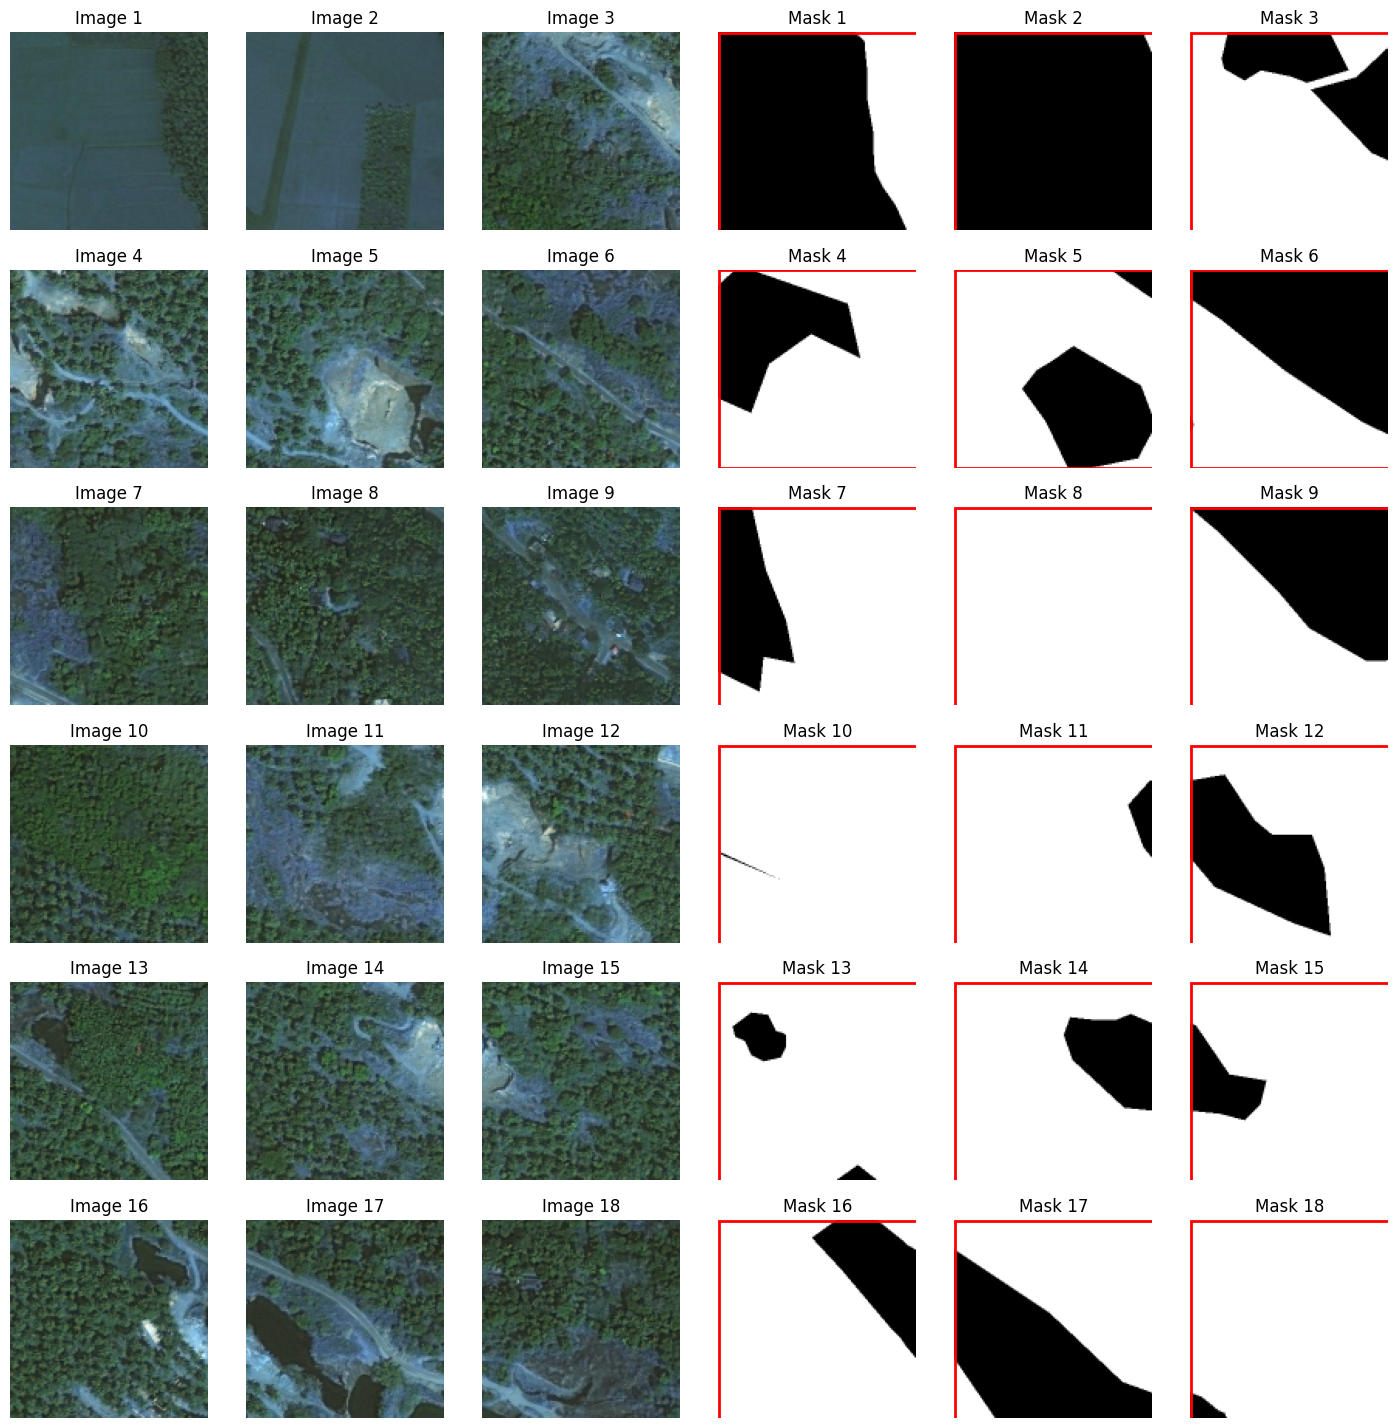

In [3]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# Create a figure with a 6x6 grid of subplots
fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(18, 18))

for j in range(6):
    train_images_subset = train_images[j*3: (j+1)*3]
    train_masks_subset = train_masks[j*3: (j+1)*3]
    # Iterate through the images and masks and plot them side by side
    for i in range(3):
        # Plot the image in the first column
        axes[j, i].imshow(train_images_subset[i])
        axes[j, i].set_title('Image {}'.format(i+1+j*3))
        axes[j, i].axis('off')

        # Plot the mask in the second column
        axes[j, i+3].imshow(train_masks_subset[i], cmap='gray')
        axes[j, i+3].set_title('Mask {}'.format(i+1+j*3))
        axes[j, i+3].axis('off')

        # Add a rectangle around the mask
        mask_shape = train_masks_subset[i].shape
        rect = Rectangle((0, 0), mask_shape[1], mask_shape[0], linewidth=2, edgecolor='r', facecolor='none')
        axes[j, i+3].add_patch(rect)

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.1)

# Display the figure
plt.show()

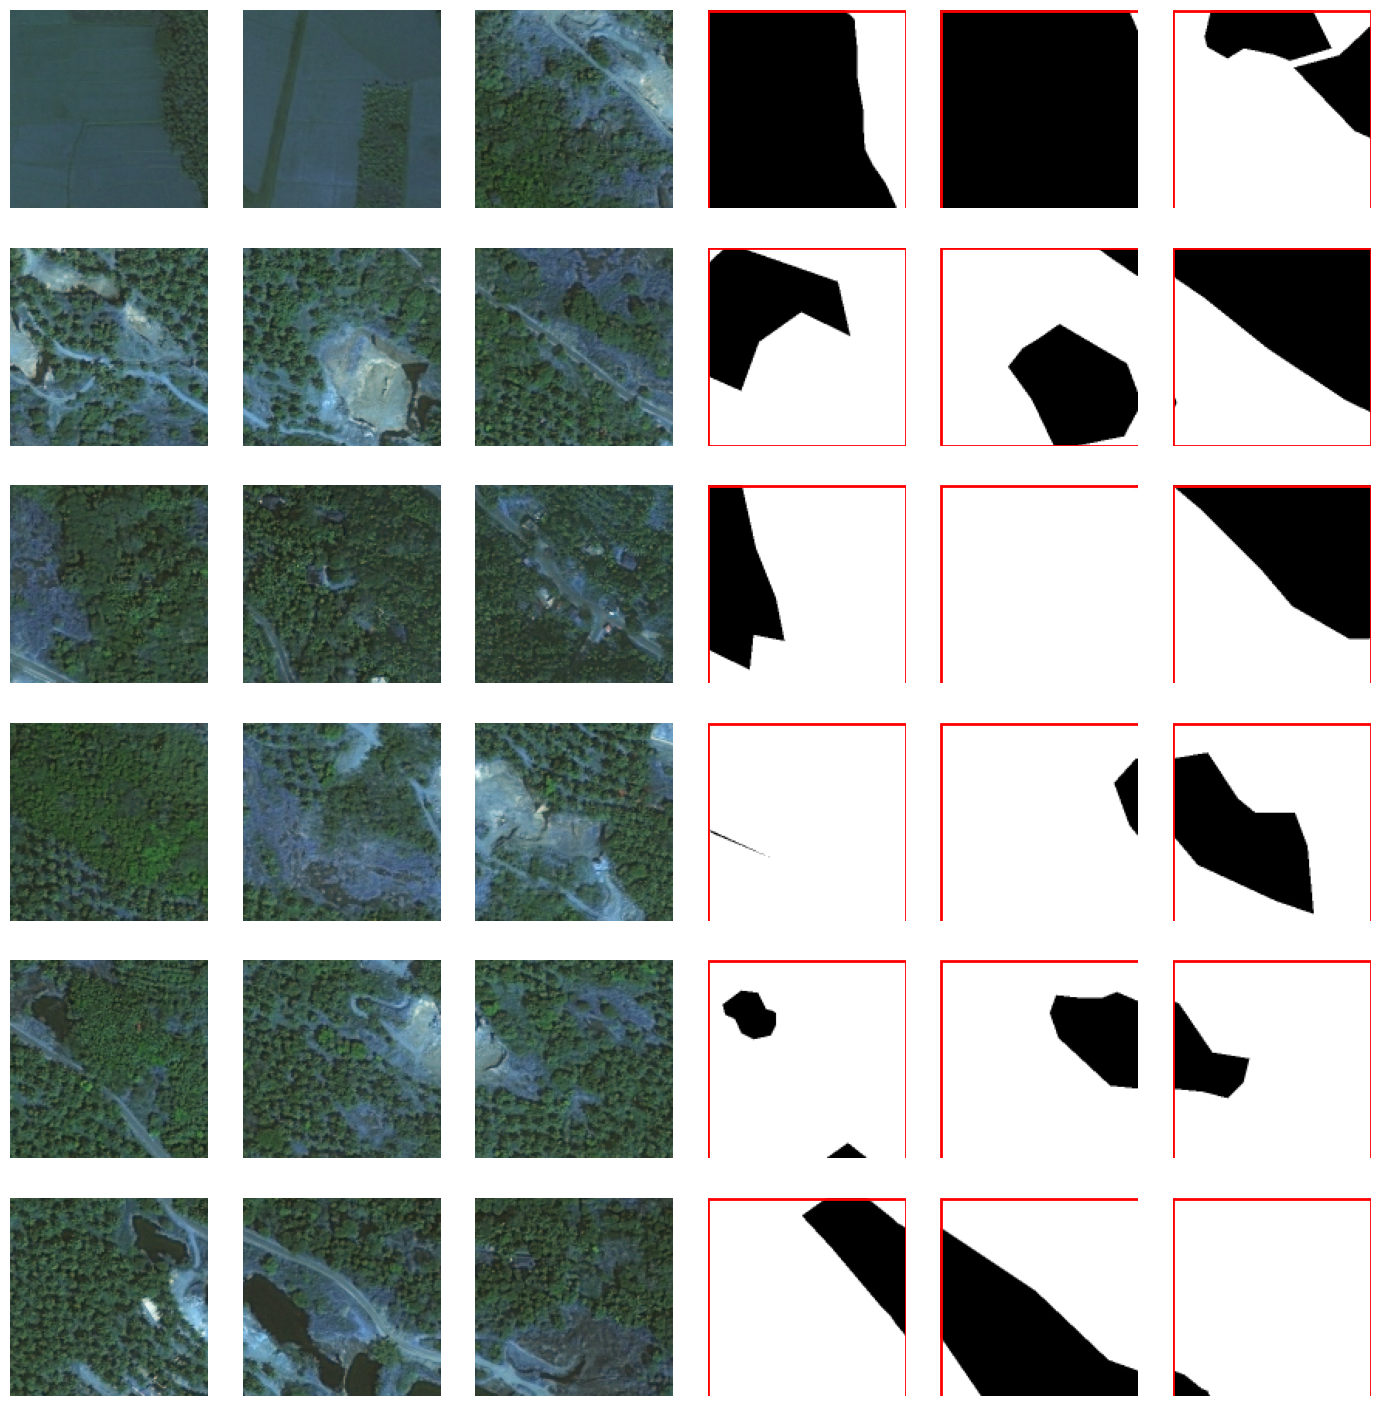

In [4]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# Create a figure with a 6x6 grid of subplots
fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(18, 18))

for j in range(6):
    train_images_subset = train_images[j*3: (j+1)*3]
    train_masks_subset = train_masks[j*3: (j+1)*3]
    # Iterate through the images and masks and plot them side by side
    for i in range(3):
        # Plot the image in the first column
        axes[j, i].imshow(train_images_subset[i])
        axes[j, i].axis('off')

        # Plot the mask in the next column
        axes[j, i+3].imshow(train_masks_subset[i], cmap='gray')
        axes[j, i+3].axis('off')

        # Add a rectangle around the mask
        mask_shape = train_masks_subset[i].shape
        rect = Rectangle((0, 0), mask_shape[1], mask_shape[0], linewidth=2, edgecolor='r', facecolor='none')
        axes[j, i+3].add_patch(rect)

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0)

# Display the figure
plt.show()

In [5]:
from tensorflow import keras
from tensorflow.keras import layers

def get_model(img_size):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(2)(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(previous_block_activation)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, strides=2, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        # Project residual
        residual = layers.Conv2DTranspose(filters, 3, strides=2, padding="same")(previous_block_activation)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(1, 1, activation="sigmoid", padding="same")(x)

    # Threshold the output to get binary predictions
    # binary_outputs = layers.Lambda(lambda x: keras.backend.round(x))(outputs)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 32)   896         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 64, 64, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

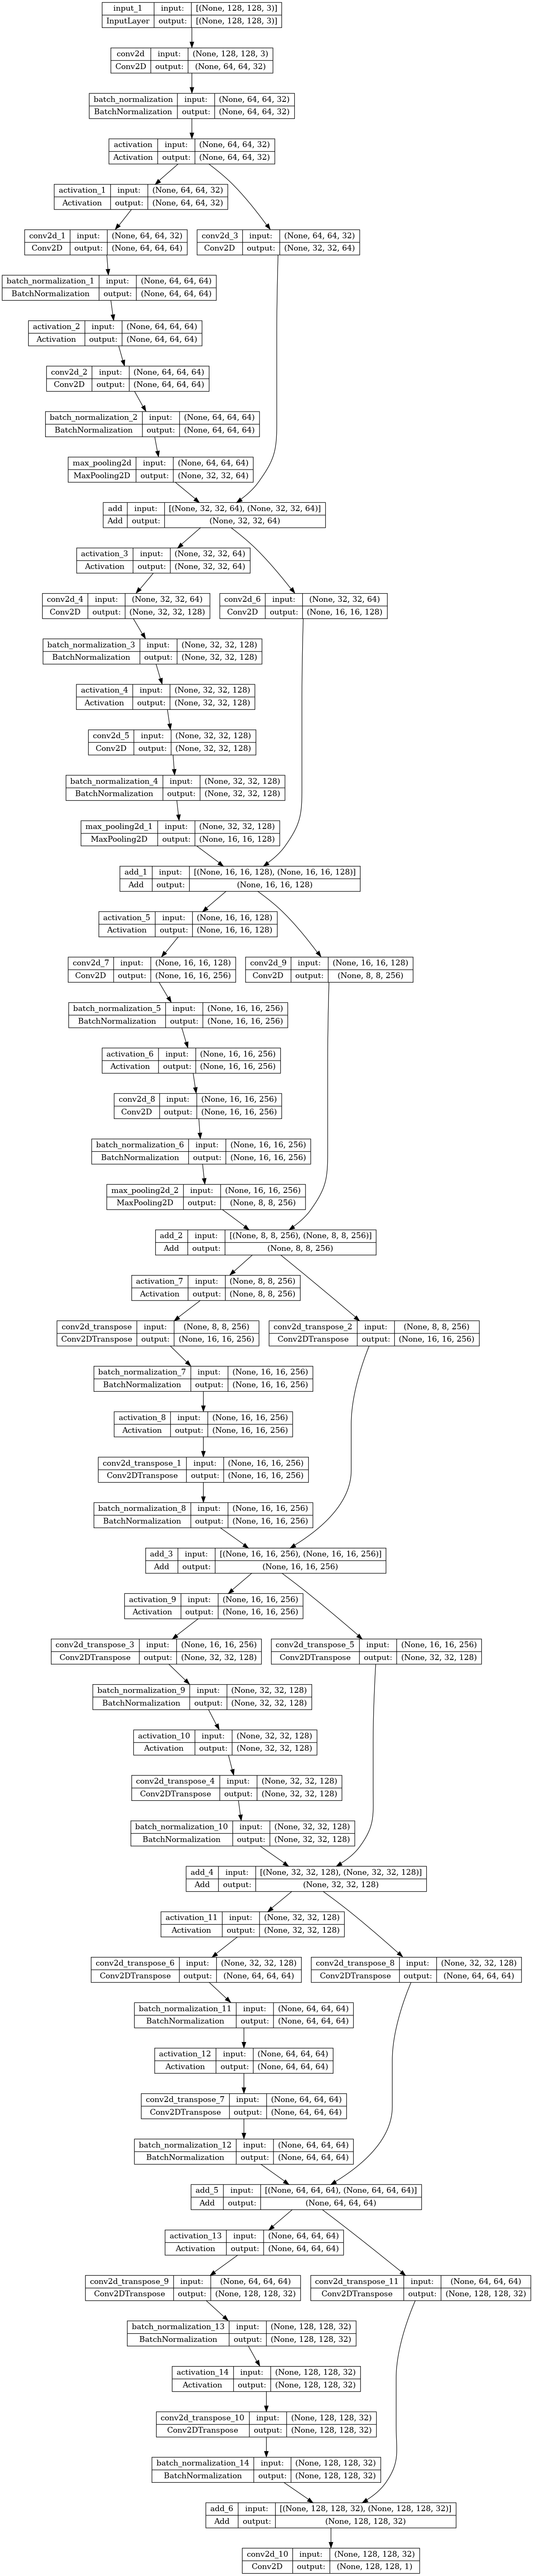

In [6]:
from keras.utils import plot_model
import tensorflow as tf

input_shape = (128, 128, 3) # Specify the input shape of your images

# Add channel dimension to the labels
# train_masks = train_masks[..., tf.newaxis]
# val_masks = val_masks[..., tf.newaxis]

# # Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

model = get_model(input_shape[:2])
model.summary()
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [7]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import MeanIoU

# Define the callbacks
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(factor=0.1, patience=5)

# Compile the model
model.compile(optimizer='adam', loss=BinaryCrossentropy(), metrics=[MeanIoU(num_classes=2)])

In [8]:
val_masks.shape

(1022, 128, 128)

In [9]:
import matplotlib.pyplot as plt

# Train the model with callbacks and collect history
history = model.fit(train_images, train_masks,
                    validation_data=(val_images, val_masks),
                    epochs=100,
                    batch_size=16,
                    callbacks=[early_stopping, reduce_lr, keras.callbacks.ModelCheckpoint("unet.h5", save_best_only=True)])

Epoch 1/100
256/256 [==============================] - 34s 64ms/step - loss: 0.5114 - mean_io_u: 0.2034 - val_loss: 1.8966 - val_mean_io_u: 0.1840 - lr: 0.0010
Epoch 2/100
256/256 [==============================] - 14s 53ms/step - loss: 0.4683 - mean_io_u: 0.2034 - val_loss: 0.7305 - val_mean_io_u: 0.1840 - lr: 0.0010
Epoch 3/100
256/256 [==============================] - 14s 54ms/step - loss: 0.4529 - mean_io_u: 0.2034 - val_loss: 0.4916 - val_mean_io_u: 0.1840 - lr: 0.0010
Epoch 4/100
256/256 [==============================] - 14s 53ms/step - loss: 0.4454 - mean_io_u: 0.2034 - val_loss: 0.4529 - val_mean_io_u: 0.1840 - lr: 0.0010
Epoch 5/100
256/256 [==============================] - 13s 52ms/step - loss: 0.4384 - mean_io_u: 0.2034 - val_loss: 0.8975 - val_mean_io_u: 0.1840 - lr: 0.0010
Epoch 6/100
256/256 [==============================] - 13s 52ms/step - loss: 0.4304 - mean_io_u: 0.2034 - val_loss: 0.7309 - val_mean_io_u: 0.1840 - lr: 0.0010
Epoch 7/100
256/256 [===================

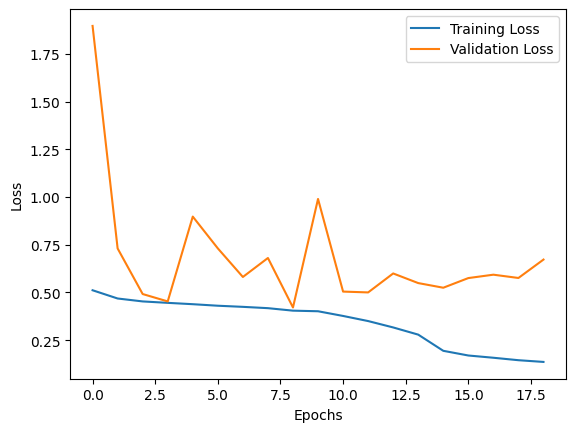

In [13]:
# Plot the training and validation curves
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

32/32 [==============================] - 1s 30ms/step


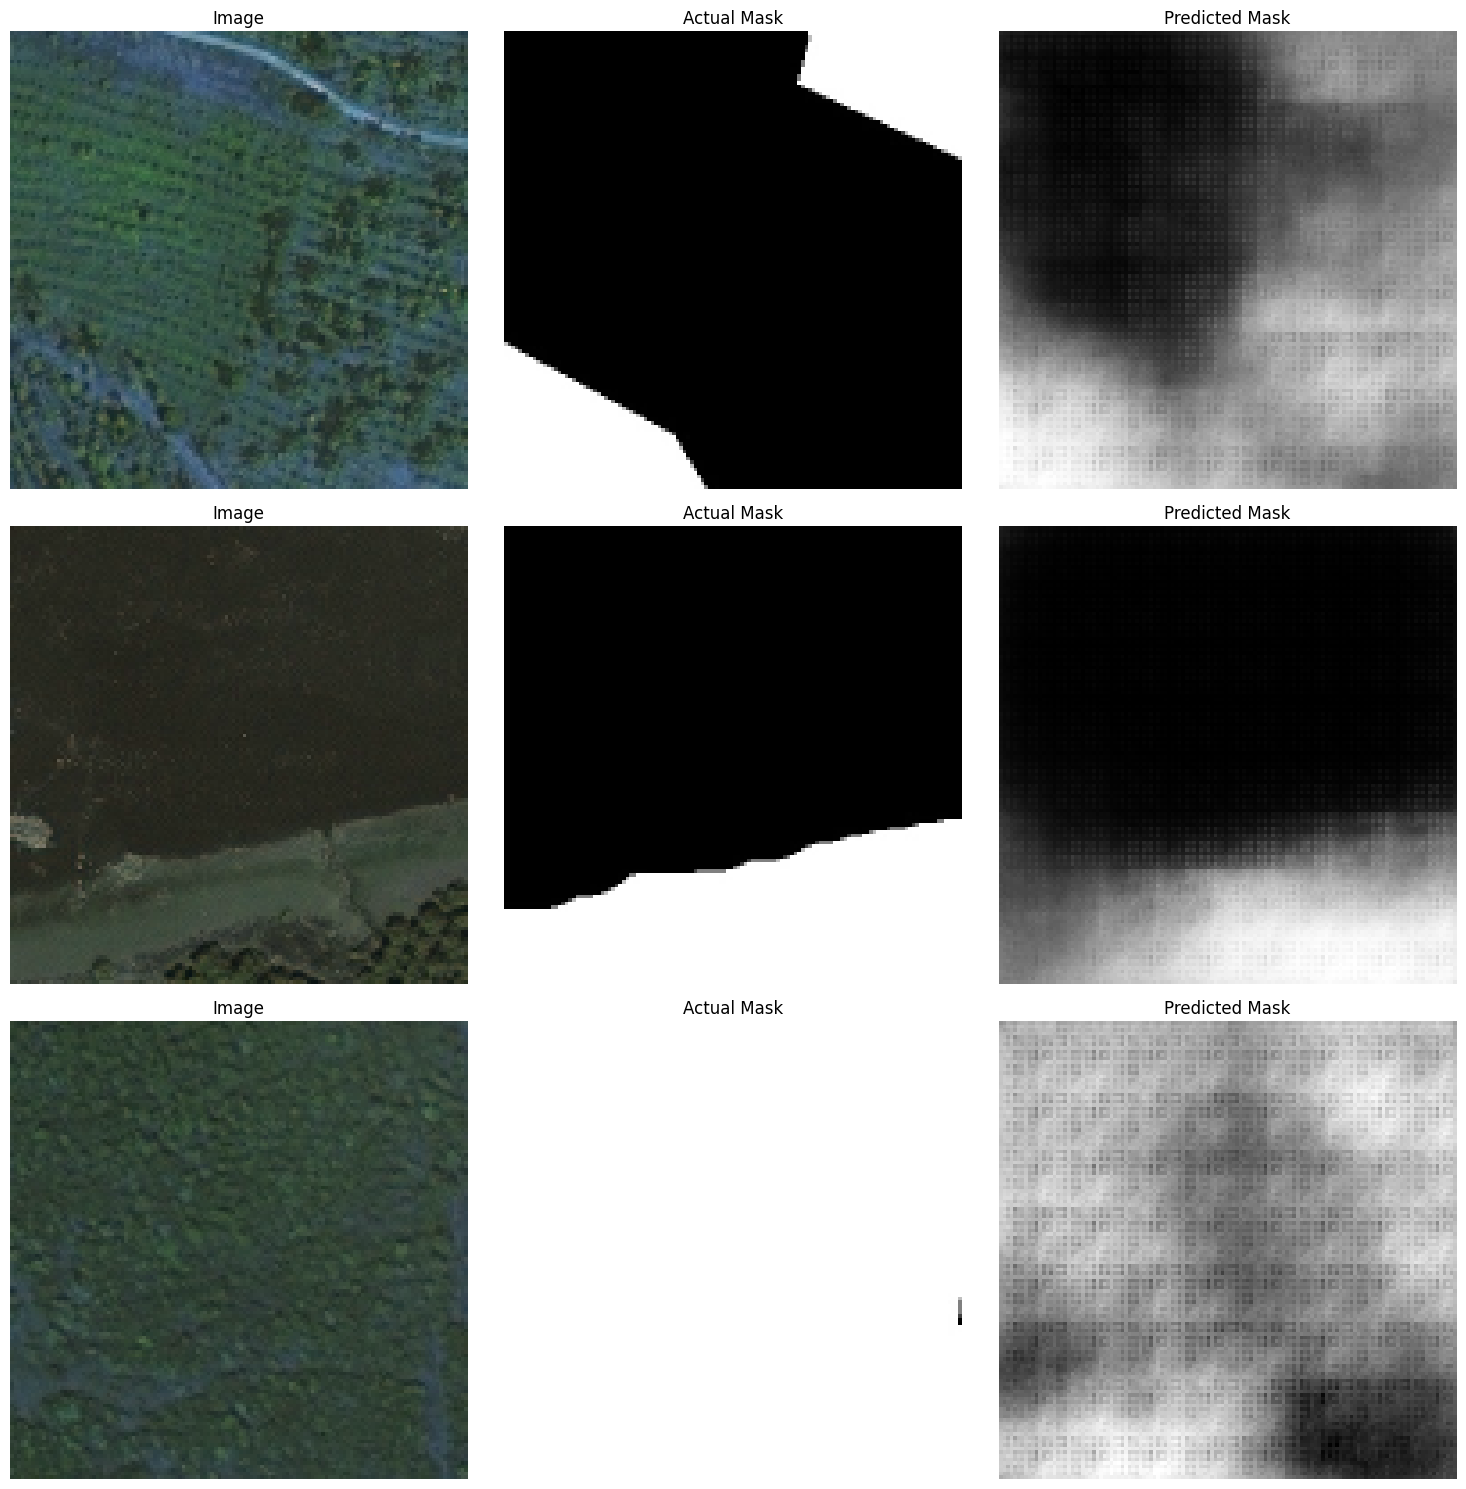

In [14]:
import numpy as np

# Make predictions on validation images
val_predictions = model.predict(val_images)

# Select random samples from validation set
sample_indices = np.random.choice(len(val_images), size=3, replace=False)
sample_images = val_images[sample_indices]
sample_masks = val_masks[sample_indices]
sample_predictions = val_predictions[sample_indices]

# Plot images with predicted and actual masks
fig, axes = plt.subplots(3, 3, figsize=(15, 15))

for i, ax in enumerate(axes):
    ax[0].imshow(sample_images[i])
    ax[0].set_title('Image')
    ax[0].axis('off')
    
    ax[1].imshow(sample_masks[i], cmap='gray')
    ax[1].set_title('Actual Mask')
    ax[1].axis('off')
    
    ax[2].imshow(sample_predictions[i], cmap='gray')
    ax[2].set_title('Predicted Mask')
    ax[2].axis('off')

plt.tight_layout()
plt.show()


32/32 [==============================] - 1s 30ms/step


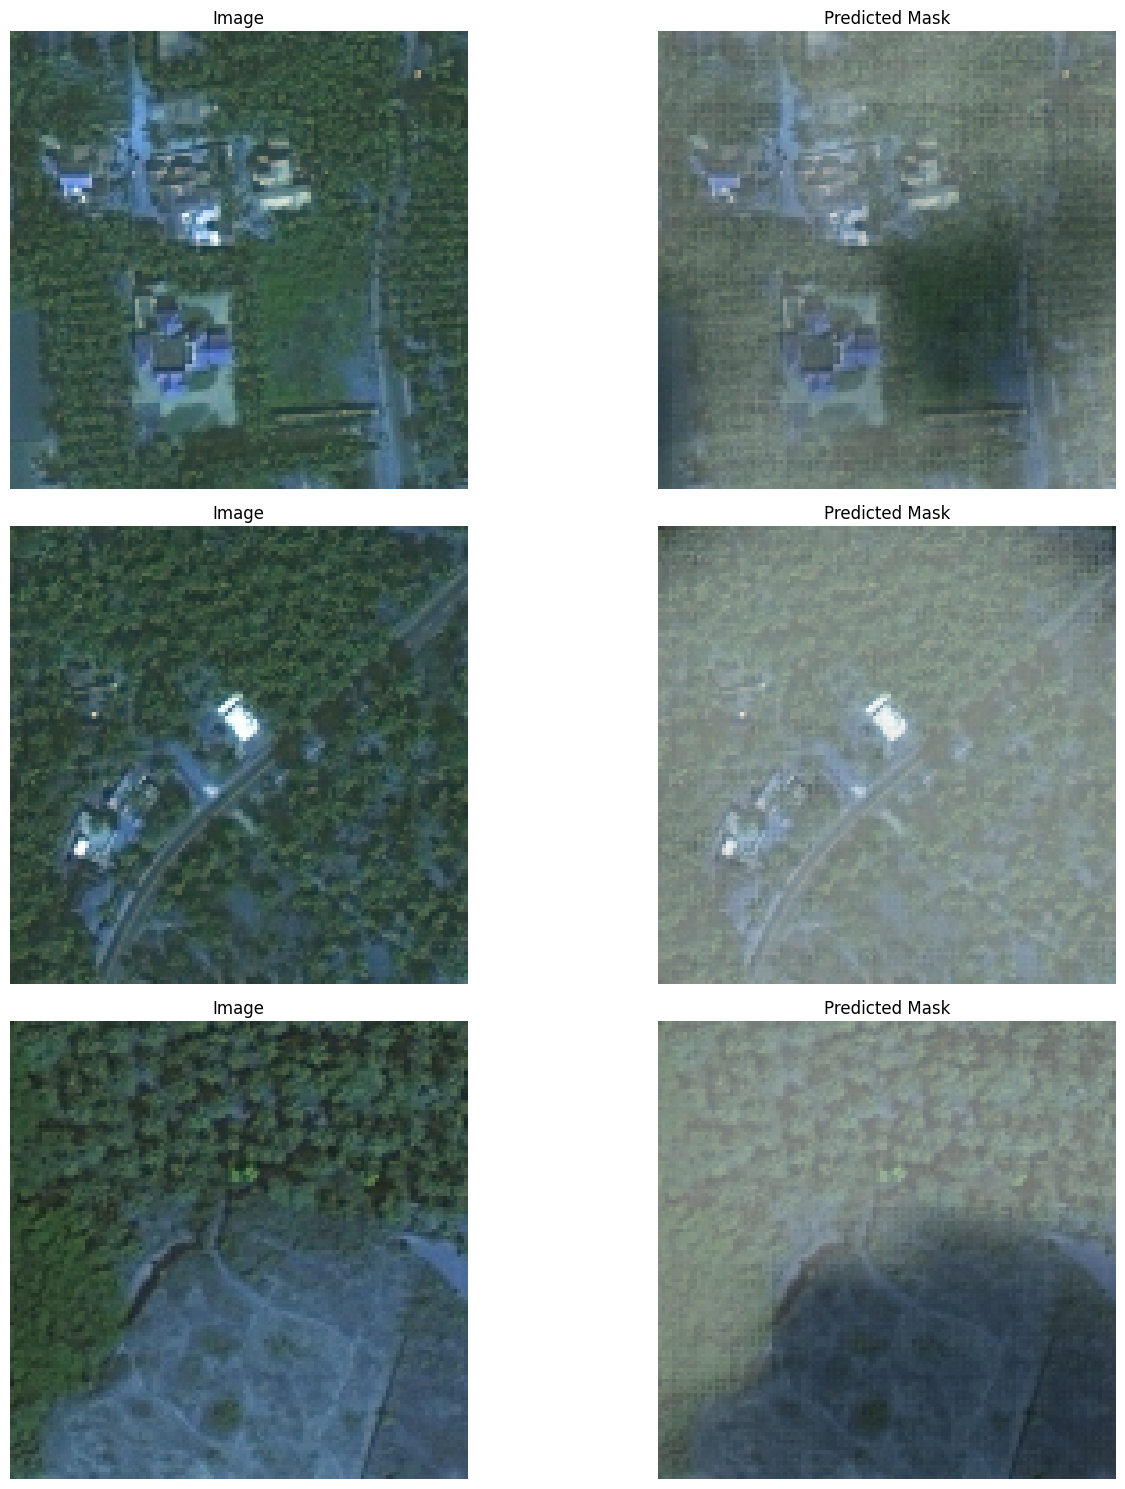

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Make predictions on validation images
val_predictions = model.predict(val_images)

# Select random samples from validation set
sample_indices = np.random.choice(len(val_images), size=3, replace=False)
sample_images = val_images[sample_indices]
sample_masks = val_masks[sample_indices]
sample_predictions = val_predictions[sample_indices]

# Plot images with predicted and actual masks
fig, axes = plt.subplots(3, 2, figsize=(15, 15))

for i, ax in enumerate(axes):
    ax[0].imshow(sample_images[i])
    ax[0].set_title('Image')
    ax[0].axis('off')

    ax[1].imshow(sample_images[i])
    ax[1].imshow(sample_predictions[i], cmap='gray', alpha=0.4)
    ax[1].set_title('Predicted Mask')
    ax[1].axis('off')

plt.tight_layout()
plt.show()


32/32 [==============================] - 1s 29ms/step


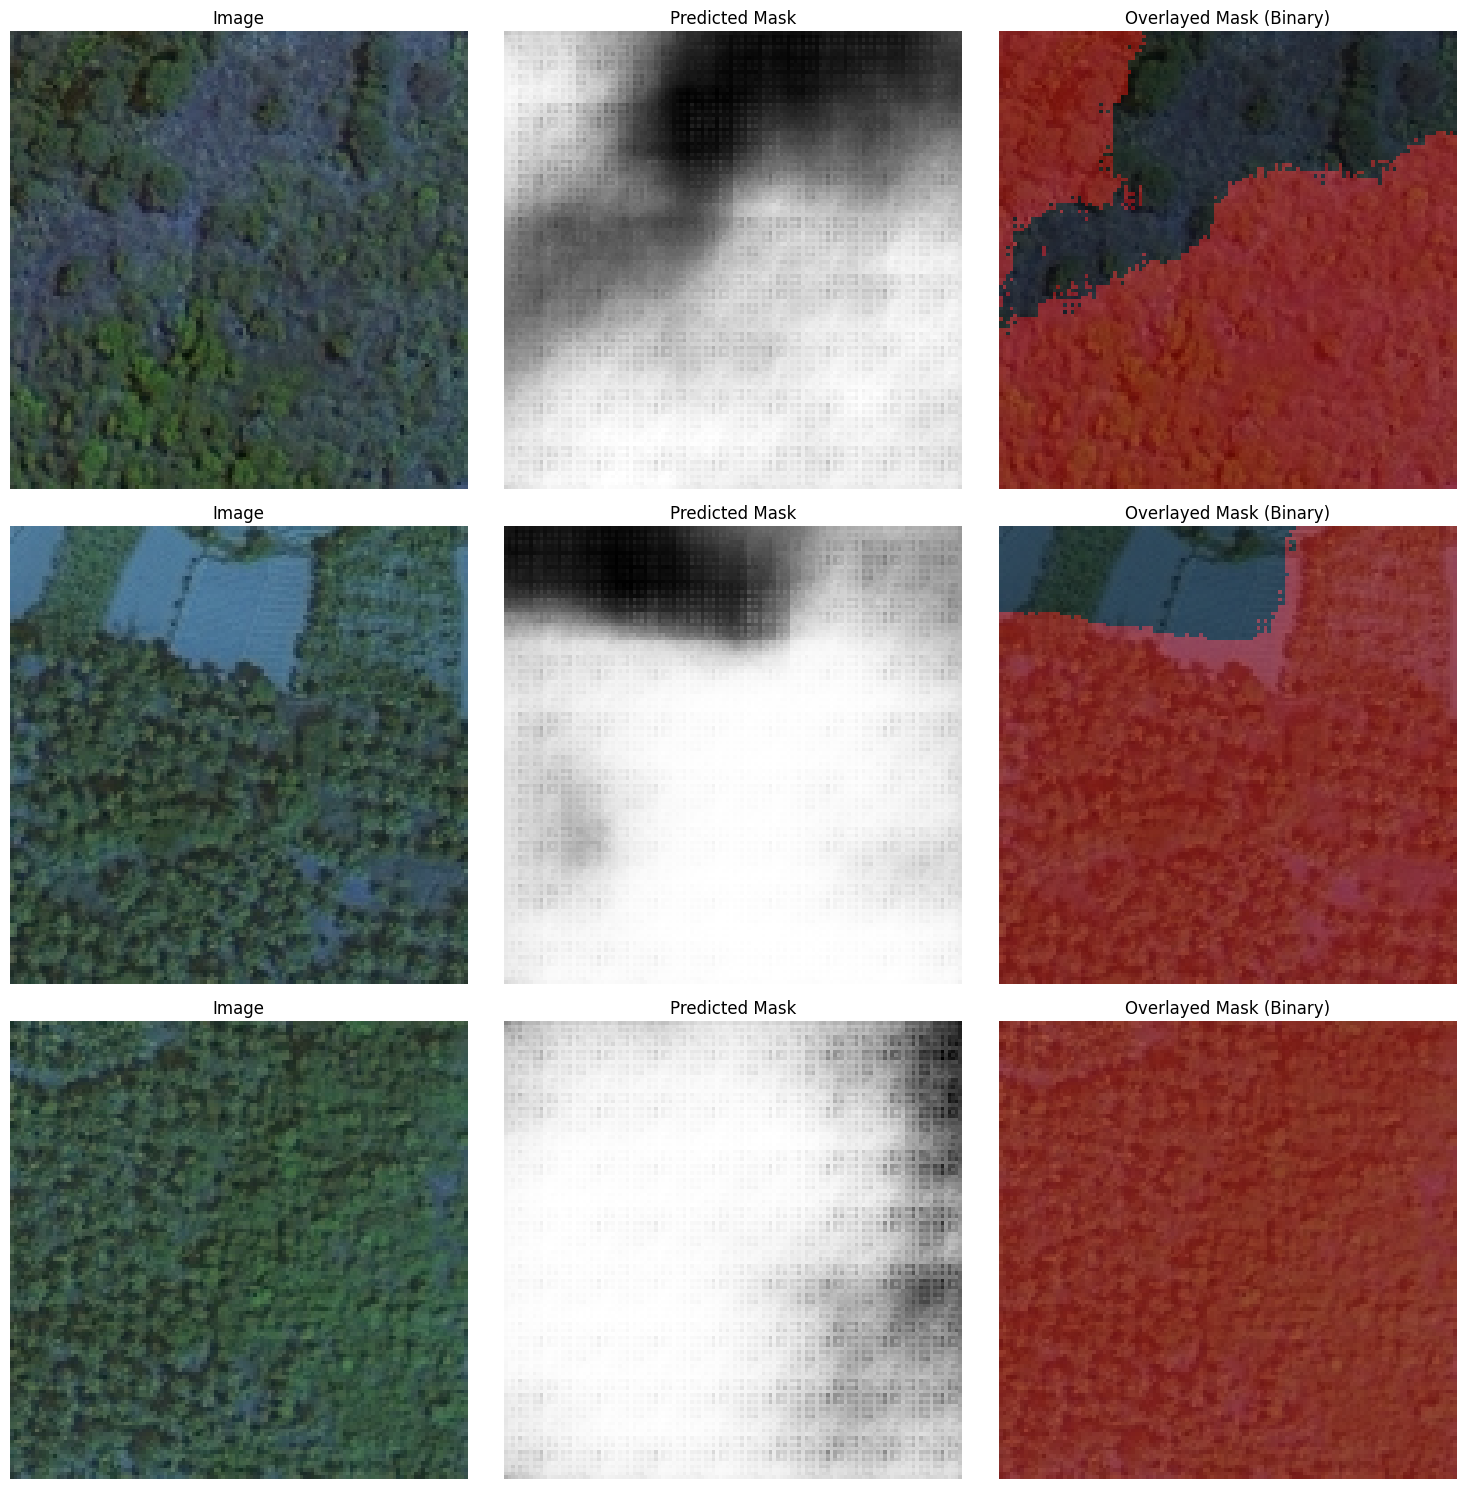

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# Make predictions on validation images
val_predictions = model.predict(val_images)

# Select random samples from validation set
sample_indices = np.random.choice(len(val_images), size=3, replace=False)
sample_images = val_images[sample_indices]
sample_masks = val_masks[sample_indices]
sample_predictions = val_predictions[sample_indices]

# Plot images with predicted and actual masks
fig, axes = plt.subplots(3, 3, figsize=(15, 15))

for i, ax in enumerate(axes):
    ax[0].imshow(sample_images[i])
    ax[0].set_title('Image')
    ax[0].axis('off')

    ax[1].imshow(sample_predictions[i], cmap='gray')
    ax[1].set_title('Predicted Mask')
    ax[1].axis('off')

    # Binarized overlayed mask
    overlay = np.zeros_like(sample_images[i])
    overlay[np.where(sample_predictions[i] > 0.5)] = 1
    ax[2].imshow(sample_images[i])
    ax[2].imshow(overlay, cmap='gray', alpha=0.4)
    ax[2].set_title('Overlayed Mask (Binary)')
    ax[2].axis('off')

plt.tight_layout()
plt.show()
